<a href="https://colab.research.google.com/github/xyzkpsf/CS-W182-CV-Project/blob/main/Retrain_Last_Layer_of_CV_Ensemble_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision.io import read_image
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import time
import copy
import os
import sys

In [ ]:
!unzip '/content/drive/MyDrive/Spring 2021/CS 182/tiny-imagenet-200.zip'

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, val_label_dir, img_dir, train_path, transform=None, target_transform=None):
        super(CustomImageDataset, self).__init__()
        self.val_label_file = pd.read_csv(val_label_dir, delimiter = "\t", names=["pics", "labels", "_1", "_2", "_3", "_4"])
        self.img_labels = self.val_label_file[["pics", 'labels']]
        self.img_dir = img_dir
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(train_path)

    def __len__(self):
        return len(self.img_labels)

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def pad(self, img):
        padding = np.ones((64, 64, 2))
        img = img.reshape((64, 64, 1))
        img = np.concatenate((img, padding), axis=2)
        return img.astype(np.float32)
      
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = Image.open(img_path)
        img = copy.deepcopy(np.asarray(img))
        # if it has less than 3 channels
        if img.shape != (64, 64, 3):
            img = self.pad(img)
        #print(img.shape)
        label = self.img_labels.iloc[idx, 1]
        label = self.class_to_idx[label]
        if self.transform:
            img = self.transform(img)
        #sample = {"image": img, "label": label}
        return img, label

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/tiny-imagenet-200'

val_label_dir = '/content/tiny-imagenet-200/val/val_annotations.txt'

image_datasets = {}

image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

image_datasets['val'] = CustomImageDataset(val_label_dir, data_dir+'/val/images', 
                                           os.path.join(data_dir, 'train'),
                                           transform=data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
                                            for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#x, y = next(iter(image_datasets['val']))
#print(x, y)

In [ ]:
# No pretrained parameters


# First model
model1 = models.resnet18(pretrained=False)
model1.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 200)
model1.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model1.maxpool = nn.Sequential()
model1 = model1.to(device)


# Second model
model2 = models.resnet50(pretrained=False)
model2.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 200)
model2.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model2.maxpool = nn.Sequential()
model2 = model2.to(device)


# Third model
model3 = models.resnet101(pretrained=False)
model3.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, 200)
model3.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model3.maxpool = nn.Sequential()
model3 = model3.to(device)


#Multi GPU
#model = torch.nn.DataParallel(model, device_ids=[0, 1])


In [ ]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")
                sys.stdout.flush()
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        liveloss.update({
            'log loss': avg_loss,
            'val_log loss': val_loss,
            'accuracy': t_acc,
            'val_accuracy': val_acc
        })
                
        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, t_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print('Best Val Accuracy: {}'.format(best_acc))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Need to train each model first then load into the Ensemble class for validation.
# Change the following block for each model

In [ ]:
#Loss Function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
import gc 
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainning_model = model3
model = train_model(trainning_model, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

In [ ]:
# Don't REPLACE the old one.
# Remeber to change the temp.pt each time.
model_save_path = "/content/drive/MyDrive/CV Project Model State Dict/temp.pt"
torch.save(model.state_dict(), model_save_path)

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, model1, model2, model3):
          super(MyEnsemble,self).__init__()
          self.model1 = model1 
          self.model2 = model2 
          self.model3 = model3  

          self.model1.fc = nn.Identity()
          self.model2.fc = nn.Identity()
          self.model3.fc = nn.Identity()

          # Dimension according to the models' last layer
          self.classifier = nn.Linear(512+2048+2048, 200)

    def forward(self, x):
        x1 = self.model1(x.clone())
        x1 = x1.view(x1.size(0), -1)
        
        x2 = self.model2(x)
        x2 = x2.view(x2.size(0), -1)
        
        x3 = self.model3(x)
        x3 = x3.view(x3.size(0), -1)

        x = torch.cat((x1, x2, x3), dim=1)
        x = self.classifier(F.relu(x))

        return x

In [ ]:
def validation(model, dataloaders, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # Iterate over data.
    for i,(inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        #loss = criterion(outputs, labels)

        #running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += len(labels)
        if i % 10 == 0:
            print(  '\rIteration: {}/{}, Avg Acc: {:.4f}'.format(i+1, len(dataloaders['val']),  running_corrects/(total_samples)))
      
    #val_loss = running_loss / len(dataloaders['val'])
    val_acc = running_corrects.double() / len(dataloaders['val'])
    print(  'Fianl Acc: {:.4f}'.format(val_acc))

In [ ]:

PATH1 = "/content/drive/MyDrive/CV Project Model State Dict/ResNet18 10-Epoch.pt"
model1.load_state_dict(torch.load(PATH1))
for param in model1.parameters():
    param.requires_grad_(False)


PATH2 = "/content/drive/MyDrive/CV Project Model State Dict/ResNet50 5-Epoch.pt"
model2.load_state_dict(torch.load(PATH2))
for param in model2.parameters():
    param.requires_grad_(False)

PATH3 = "/content/drive/MyDrive/CV Project Model State Dict/ResNet101.pt"
model3.load_state_dict(torch.load(PATH3))
for param in model3.parameters():
    param.requires_grad_(False)



In [ ]:

# Only finish training model1 so far
model = MyEnsemble(model1, model2, model3)
model = model.to(device)
#validation(model, dataloaders, nn.CrossEntropyLoss())

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),   lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

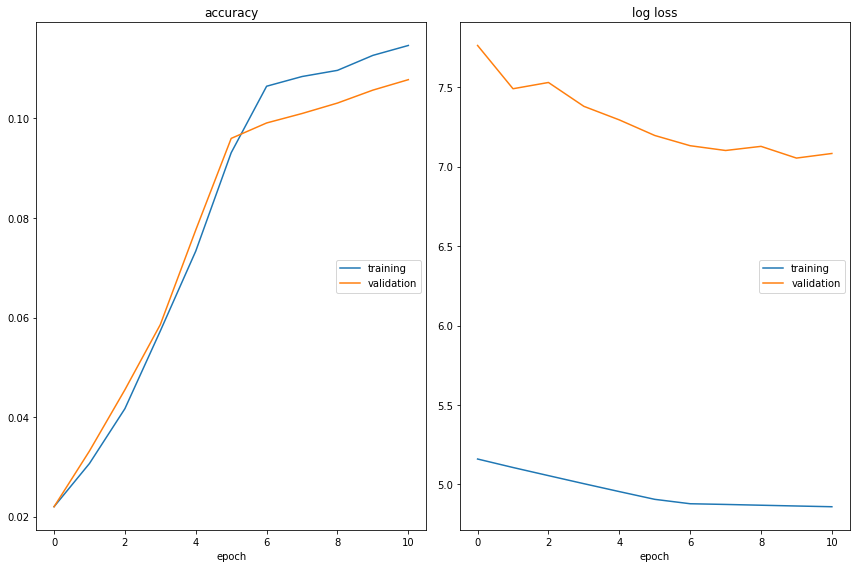

accuracy
	training         	 (min:    0.022, max:    0.115, cur:    0.115)
	validation       	 (min:    0.022, max:    0.108, cur:    0.108)
log loss
	training         	 (min:    4.860, max:    5.160, cur:    4.860)
	validation       	 (min:    7.053, max:    7.761, cur:    7.082)
Train Loss: 4.8601 Acc: 0.1147
Val Loss: 7.0820 Acc: 0.1078
Best Val Accuracy: 0.1078

Epoch 12/15
----------
Iteration: 958/1563, Loss: 309.61737060546875.

In [ ]:
trainning_model = model
model = train_model(trainning_model, dataloaders, dataset_sizes, criterion, optimizer, scheduler,
                       num_epochs=15)

In [ ]:
validation(model, dataloaders, nn.CrossEntropyLoss())